In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

random_state = 44

In [2]:
df = pd.read_csv("../features_good.csv", index_col=0)
df.dropna(inplace=True)
X = df.drop(columns=['malign', 'patient_name'])
y = df['malign']

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

In [4]:
from sklearn.feature_selection import VarianceThreshold

transformer = VarianceThreshold()
transformer.fit(X)
X = transformer.transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [6]:
from sklearn.feature_selection import GenericUnivariateSelect, \
    VarianceThreshold, mutual_info_classif, chi2, f_classif
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

percentiles = [30, 60, 67, 90, 93, 95, 99]
results = {"mutual_info_classif": [], "chi2": [], "f_classif": []}
GUS_pipe_best_dict = {}
score_funcs = [mutual_info_classif, chi2, f_classif]
best_f1 = 0
GUS_pipe_best = None
percentile_best = None
for fun, name in zip(score_funcs, results.keys()):
    best_f1 = 0
    for percentile in percentiles:
        GUS_pipe = Pipeline([("FeatureSelection", GenericUnivariateSelect(score_func=fun, param=percentile)),
                             ("SVM", LinearSVC(random_state=random_state, max_iter=10**4))])
        GUS_pipe.fit(X_train,y_train)
        f1 = f1_score(y_val, GUS_pipe.predict(X_val))
        results[name].append(f1)
        if f1 > best_f1:
            best_f1 = f1
            GUS_pipe_best = GUS_pipe
            percentile_best = percentile
    GUS_pipe_best_dict[name] = GUS_pipe_best
    print(fun, percentile_best, best_f1)

print(GUS_pipe_best.get_params())

<function mutual_info_classif at 0x0000016DB492EAF8> 93 0.7878787878787877
<function chi2 at 0x0000016DB3E74318> 95 0.7878787878787877
<function f_classif at 0x0000016DB3E56D38> 99 0.7878787878787877
{'memory': None, 'steps': [('FeatureSelection', GenericUnivariateSelect(param=99)), ('SVM', LinearSVC(max_iter=10000, random_state=44))], 'verbose': False, 'FeatureSelection': GenericUnivariateSelect(param=99), 'SVM': LinearSVC(max_iter=10000, random_state=44), 'FeatureSelection__mode': 'percentile', 'FeatureSelection__param': 99, 'FeatureSelection__score_func': <function f_classif at 0x0000016DB3E56D38>, 'SVM__C': 1.0, 'SVM__class_weight': None, 'SVM__dual': True, 'SVM__fit_intercept': True, 'SVM__intercept_scaling': 1, 'SVM__loss': 'squared_hinge', 'SVM__max_iter': 10000, 'SVM__multi_class': 'ovr', 'SVM__penalty': 'l2', 'SVM__random_state': 44, 'SVM__tol': 0.0001, 'SVM__verbose': 0}


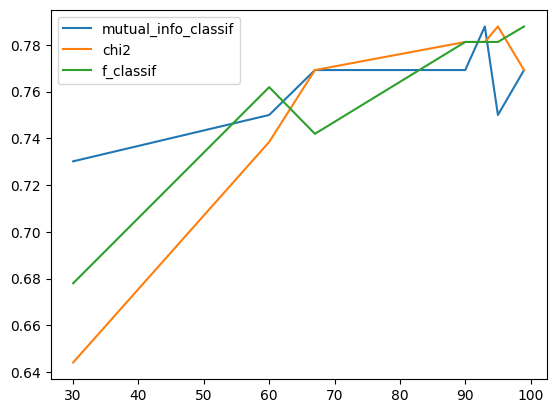

In [7]:
for fun, name in zip(score_funcs, results.keys()):
    plt.plot(percentiles, results[name])
plt.legend(results.keys())
plt.show()

In [8]:
from sklearn.feature_selection import GenericUnivariateSelect, RFECV, \
    VarianceThreshold, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

GUS_MI = GUS_pipe_best_dict["mutual_info_classif"]
GUS_CHI = GUS_pipe_best_dict["chi2"]
GUS_FC = GUS_pipe_best_dict["f_classif"]

f1_scorer = make_scorer(f1_score)
clf_RFECV = RFECV(estimator=LinearSVC(random_state=random_state, max_iter=500),
                  scoring=f1_scorer,
                  step=0.05, n_jobs=-1)
# SFS = Pipeline([("FeatureSelection", SequentialFeatureSelector(
#                                 estimator=LogisticRegression(random_state=random_state, max_iter=100), 
#                                 scoring=f1_scorer, 
#                                 n_jobs=-1)),
#                 ("LogisticRegression", LogisticRegression(random_state=random_state, max_iter=10**4))])

clfs = [GUS_MI, GUS_CHI, GUS_FC, clf_RFECV]
clfs_names = ["GUS Mutual Info", "GUS chi-squared", "GUS ANOVA F-value", "RFECV"]

for clf, name in zip(clfs, clfs_names):
    print("Fitting: ", name)
    clf = clf.fit(X_train, y_train)

Fitting:  GUS Mutual Info
Fitting:  GUS chi-squared
Fitting:  GUS ANOVA F-value
Fitting:  RFECV


c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\mlech\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iter

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_train)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_train)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_train, y_pred))
    results['F1 score'].append(f1_score(y_train, y_pred))
    results['Precision'].append(precision_score(y_train, y_pred))
    results['Recall'].append(recall_score(y_train, y_pred))

results_df = pd.DataFrame(results)
print("Performance on TRAINING set")
results_df.head(len(clfs_names))

Performance on TRAINING set


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.893321,0.792043,0.872510,0.725166
1,GUS chi-squared,0.899814,0.802198,0.897541,0.725166
2,GUS ANOVA F-value,0.903525,0.810909,0.899194,0.738411
3,RFECV,0.899814,0.808511,0.870229,0.754967


In [10]:
y_pred = clf.predict(X_val)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_val)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))

results_df = pd.DataFrame(results)
print("Performance on VALIDATION set")
results_df.head(len(clfs_names))

Performance on VALIDATION set


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.888889,0.769231,0.862069,0.694444
1,GUS chi-squared,0.896296,0.787879,0.866667,0.722222
2,GUS ANOVA F-value,0.896296,0.787879,0.866667,0.722222
3,RFECV,0.888889,0.769231,0.862069,0.694444


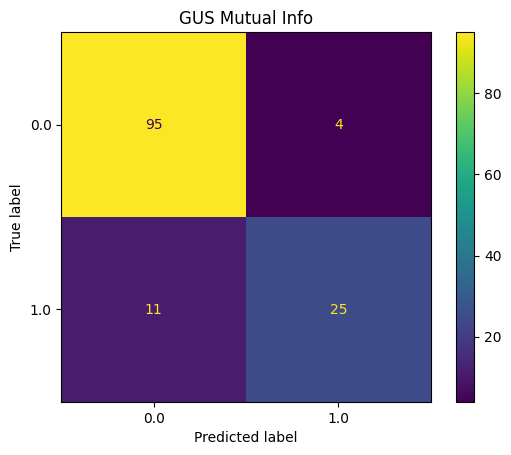

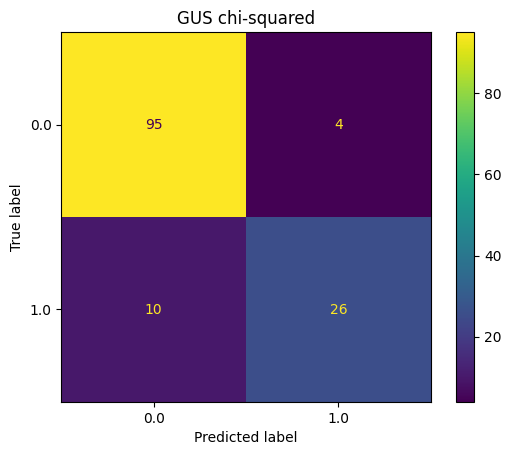

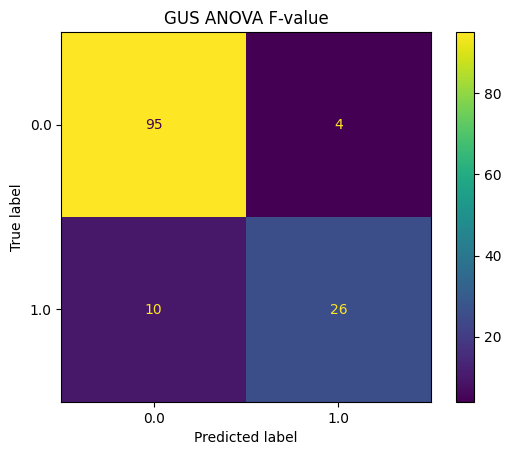

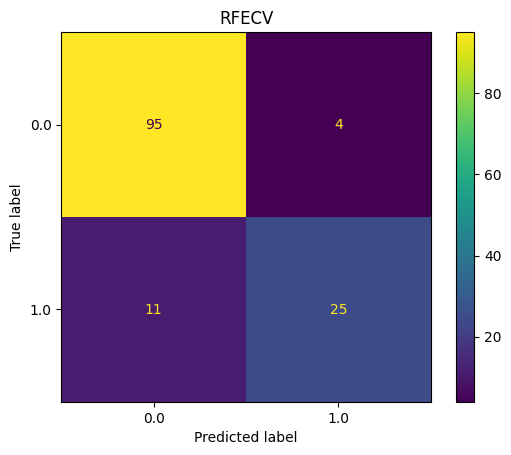

In [11]:
for clf, name in zip(clfs, clfs_names):
    y_pred = ys_pred[name]
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

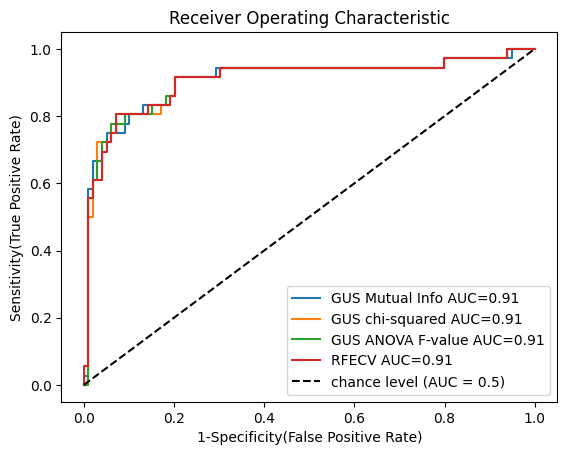

In [12]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
ys_pred_proba = {}
clfs_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    y_pred_proba = clf.decision_function(X_val)
    # y_pred_proba = y_pred_proba[:, 1]
    ys_pred_proba[name] = y_pred_proba

    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    thresholds = np.append(thresholds, 0.5)
    clfs_thresholds[name] = thresholds
    plt.plot(fpr,tpr,label=f"{name} AUC={roc_auc:.2f}"+str())

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

In [13]:
best_thresholds = {}
for clf, name in zip(clfs, clfs_names):
    best_f1 = 0
    best_th = None
    for threshold in clfs_thresholds[name]:
        y_pred = ys_pred_proba[name] > threshold
        f1 = f1_score(y_val, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = threshold
    best_thresholds[name] = best_th

In [14]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred = ys_pred_proba[name] > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_val, y_pred))
    results['F1 score'].append(f1_score(y_val, y_pred))
    results['Precision'].append(precision_score(y_val, y_pred))
    results['Recall'].append(recall_score(y_val, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on VALIDATION")
results_df.head(len(clfs_names))

Results after threshold adjustment on VALIDATION


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,GUS Mutual Info,0.896296,0.787879,0.866667,0.722222,-0.020941
1,GUS chi-squared,0.896296,0.800000,0.823529,0.777778,-0.103746
2,GUS ANOVA F-value,0.888889,0.782609,0.818182,0.750000,-0.090681
3,RFECV,0.888889,0.788732,0.800000,0.777778,-0.076056


In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)

results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': []}
ys_pred = {}

for clf, name in zip(clfs, clfs_names):
    y_pred = clf.predict(X_test)
    ys_pred[name] = y_pred
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))

results_df = pd.DataFrame(results)
print("Results WITHOUT threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results WITHOUT threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall
0,GUS Mutual Info,0.866667,0.709677,0.880000,0.594595
1,GUS chi-squared,0.866667,0.718750,0.851852,0.621622
2,GUS ANOVA F-value,0.859259,0.698413,0.846154,0.594595
3,RFECV,0.859259,0.698413,0.846154,0.594595


In [19]:
results = {'Name': [], 'Accuracy': [], 'F1 score': [], 'Precision': [], 'Recall': [], 'Best Th.': []}
ys_pred_test_proba = {}

for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.decision_function(X_test)
    # y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    results['Name'].append(name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1 score'].append(f1_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['Best Th.'].append(best_th)

results_df = pd.DataFrame(results)
print("Results after threshold adjustment on TEST data")
results_df.head(len(clfs_names))

Results after threshold adjustment on TEST data


,Name,Accuracy,F1 score,Precision,Recall,Best Th.
0,GUS Mutual Info,0.874074,0.730159,0.884615,0.621622,-0.020941
1,GUS chi-squared,0.874074,0.746269,0.833333,0.675676,-0.103746
2,GUS ANOVA F-value,0.874074,0.746269,0.833333,0.675676,-0.090681
3,RFECV,0.859259,0.716418,0.800000,0.648649,-0.076056


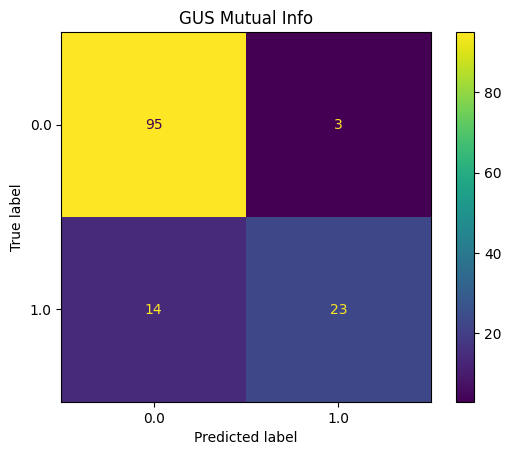

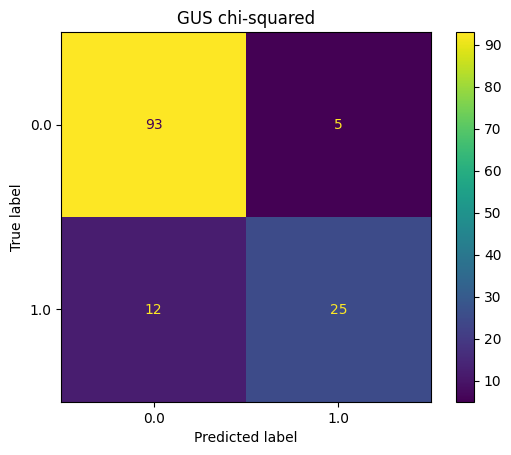

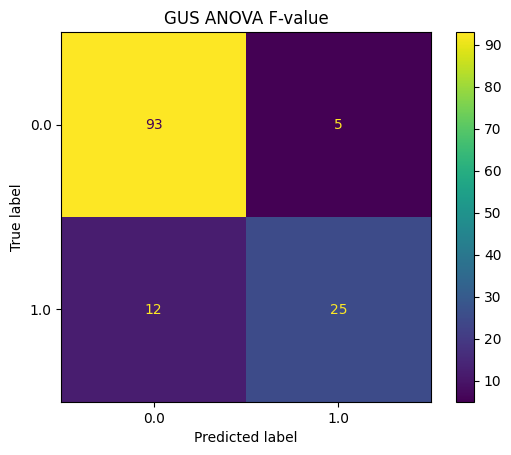

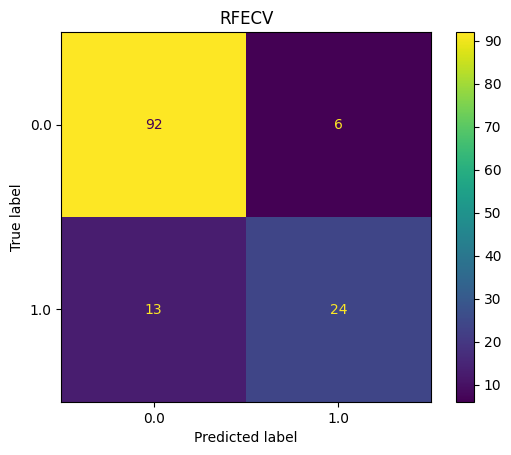

In [20]:
for clf, name in zip(clfs, clfs_names):
    best_th = best_thresholds[name]
    y_pred_proba = clf.decision_function(X_test)
    # y_pred_proba = clf.predict_proba(X_test)[:, 1]
    ys_pred_test_proba[name] = y_pred_proba
    y_pred = y_pred_proba > best_th
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title(f"{name}")
    plt.show()

In [21]:
print(clf["LogisticRegression"].coef_[0][:2])

TypeError: 'RFECV' object is not subscriptable

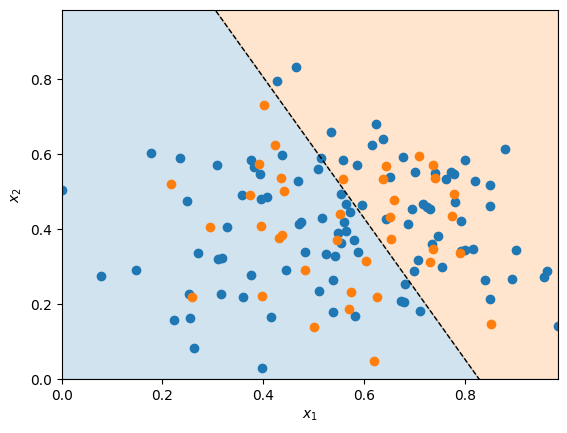

In [ ]:
X = X_test[:,:2]
Y = y_test
# Retrieve the model parameters.
b = clf["LogisticRegression"].intercept_[0]
w1, w2 = clf["LogisticRegression"].coef_[0][:2].T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = np.min(X_test[:,:2]), np.max(X_test[:,:2])
# spread = xmax - xmin
# xmin, xmax = xmin - 0.5*spread, xmax + 0.5*spread
ymin, ymax = xmin, xmax
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X[Y==0].T)
plt.scatter(*X[Y==1].T)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()